In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

# Defina el directorio donde se encuentra el conjunto de datos
base_dir = 'C:/UE/TFM/COCHES_IMAGENES'

def print_directory_structure(base_dir):
    for brand in os.listdir(base_dir):
        brand_path = os.path.join(base_dir, brand)
        if os.path.isdir(brand_path):
            print(f'Brand: {brand}')
            for model in os.listdir(brand_path):
                model_path = os.path.join(brand_path, model)
                if os.path.isdir(model_path):
                    print(f'  Modelo: {model}')
    print()

# Parametros
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
epochs = 10

# Crear un ImageDataGenerator para el entrenamiento y la validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True,
    featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=validation_split
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Set as training data
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    shuffle=True
)

# Print the partition details
print("Tamaño del conjunto de entrenamiento:", train_generator.samples)
print("Tamaño del conjunto de validación:", validation_generator.samples)
print("Índices de clase:", train_generator.class_indices)

Found 14114 images belonging to 8 classes.
Found 3525 images belonging to 8 classes.
Training set size: 14114
Validation set size: 3525
Class indices: {'Abarth': 0, 'Audi': 1, 'BMW': 2, 'Citroen': 3, 'Hyundai': 4, 'Peugeot': 5, 'Seat': 6, 'Toyota': 7}


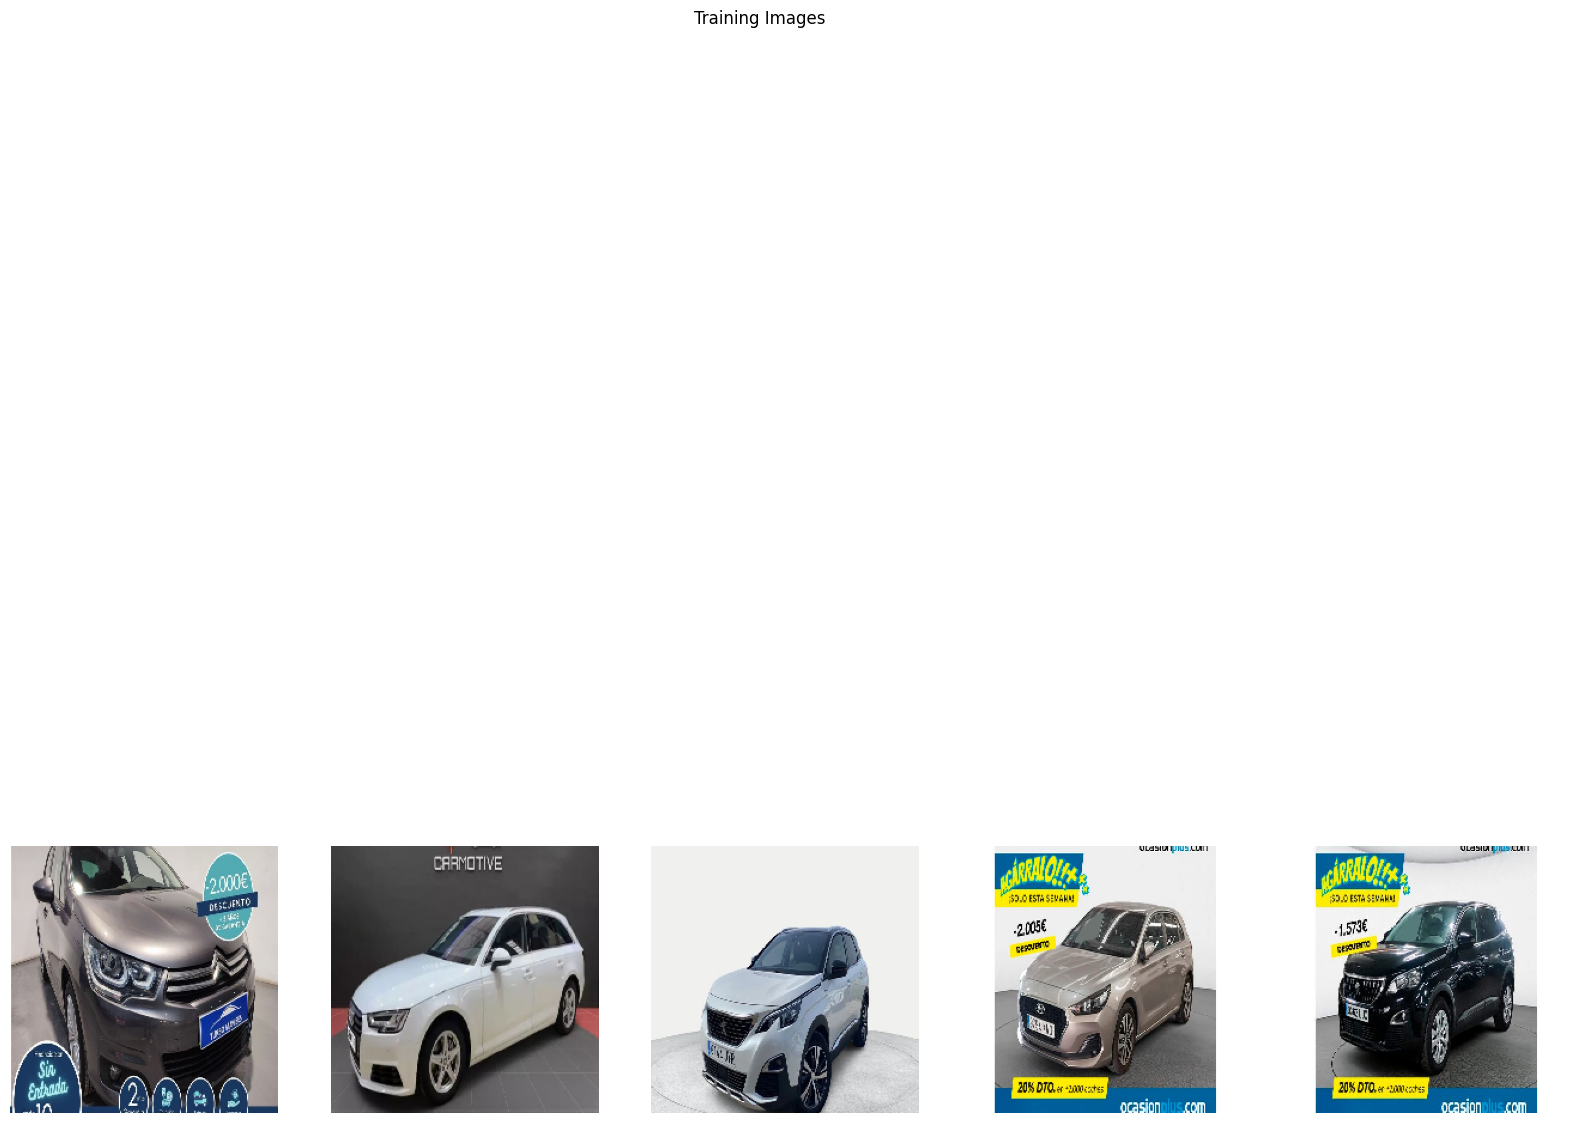

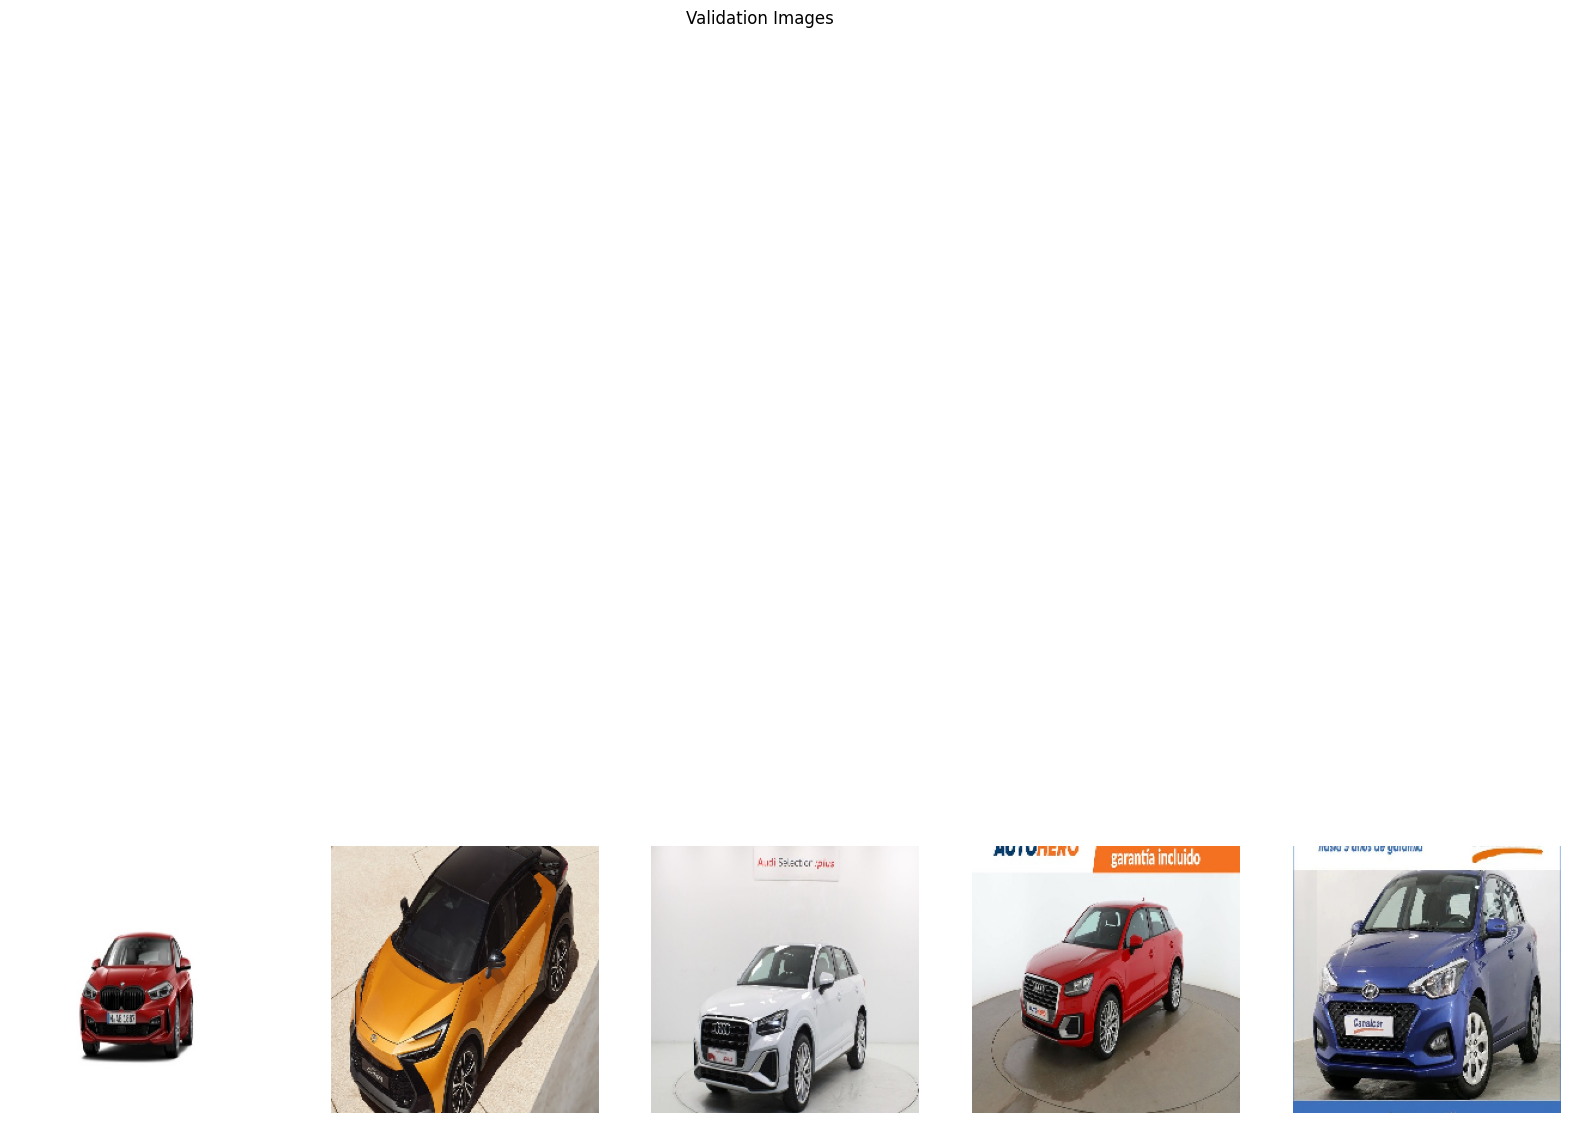

In [2]:
# Function to plot images with file paths
def plot_images_with_paths(generator, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    batch = next(generator)  # Get next batch of images and labels
    for i in range(num_images):
        img = batch[0][i]
        path = generator.filepaths[generator.index_array[i]]  # Get file path
        axes[i].imshow(img)
        #axes[i].set_title(f'Path: {os.path.basename(path)}')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Display some training images with file paths
plot_images_with_paths(train_generator, 'Training Images')

# Display some validation images with file paths
plot_images_with_paths(validation_generator, 'Validation Images')

Modelo Resnet

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
import os


def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

def create_vgg_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

#old version
#def create_modelo_tfm(input_shape, num_classes):
    #model = Sequential([
        #Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        #MaxPooling2D((2, 2)),
        #Conv2D(64, (3, 3), activation='relu'),
        #MaxPooling2D((2, 2)),
        #Conv2D(128, (3, 3), activation='relu'),
        #MaxPooling2D((2, 2)),
        #Flatten(),
        #Dense(512, activation='relu'),
        #Dropout(0.5),
        #Dense(num_classes, activation='softmax')
    #])
    #return model
#new version

def create_modelo_tfm(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Añadir "dropout" para regularización
        Dense(256, activation='relu'),  # Capa densa adicional para mayor complejidad
        Dropout(0.5),  # Añadir "dropout" para regularización
        Dense(num_classes, activation='softmax')
    ])
    return model




# Crear modelos
input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)

resnet_model = create_resnet_model(input_shape, num_classes)
vgg_model = create_vgg_model(input_shape, num_classes)
modelo_tfm = create_modelo_tfm(input_shape, num_classes)

# Compilar modelos
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

modelo_tfm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


c:\UE\TFM\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
resnet_model.summary()

In [ ]:
vgg_model.summary()

In [ ]:
modelo_tfm.summary()

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#modelo_tfm.save('C:/UE/TFM/checkpoint/modelo_tfm_best.hdf5')
#vgg_model.save('C:/UE/TFM/checkpoint/vgg_model_best.hdf5')
#resnet_model.save('C:/UE/TFM/checkpoint/resnet_model_best.hdf5')

# Definir puntos de control del modelo para guardar los mejores modelos durante el entrenamiento
checkpoint_modelo_tfm = ModelCheckpoint('C:/UE/TFM/checkpoint/modelo_tfm_best.keras',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1)

checkpoint_vgg = ModelCheckpoint('C:/UE/TFM/checkpoint/vgg_model_best.keras',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max',
                                 verbose=1)

checkpoint_resnet = ModelCheckpoint('C:/UE/TFM/checkpoint/resnet_model_best.keras',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1)

# Definir "early stopping" para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)


# Modelo TFM
history_custom = modelo_tfm.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint_modelo_tfm,early_stopping]
)


Epoch 1/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4723 - loss: 1.4653
Epoch 1: val_accuracy improved from -inf to 0.52358, saving model to C:/UE/TFM/checkpoint/modelo_tfm_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 330s 746ms/step - accuracy: 0.4724 - loss: 1.4652 - val_accuracy: 0.5236 - val_loss: 1.3103
Epoch 2/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 4:34 623ms/step - accuracy: 0.5625 - loss: 1.1689
Epoch 2: val_accuracy did not improve from 0.52358
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - accuracy: 0.5625 - loss: 1.1689 - val_accuracy: 0.2000 - val_loss: 1.2378
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.5779 - loss: 1.1689
Epoch 3: val_accuracy improved from 0.52358 to 0.59261, saving model to C:/UE/TFM/checkpoint/modelo_tfm_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 329s 743ms/step - accuracy: 0.5780 - loss: 1.1688 - val_accuracy: 0.5926 - val_loss: 1.1389
Epoch 4/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 4:34 625ms/step - accuracy: 0.6562 - loss: 0.9907
Epoch 

In [7]:
# Train VGG16 model
# Assuming you've defined vgg_model as in the previous code
history_vgg = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint_vgg,early_stopping]
)

Epoch 1/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2725 - loss: 1.8849
Epoch 1: val_accuracy improved from -inf to 0.44631, saving model to C:/UE/TFM/checkpoint/vgg_model_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 963s 2s/step - accuracy: 0.2727 - loss: 1.8847 - val_accuracy: 0.4463 - val_loss: 1.6837
Epoch 2/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 12:08 2s/step - accuracy: 0.4688 - loss: 1.7598

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.44631
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.4688 - loss: 1.7598 - val_accuracy: 0.2000 - val_loss: 1.7727
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4617 - loss: 1.6311
Epoch 3: val_accuracy improved from 0.44631 to 0.52557, saving model to C:/UE/TFM/checkpoint/vgg_model_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 926s 2s/step - accuracy: 0.4617 - loss: 1.6309 - val_accuracy: 0.5256 - val_loss: 1.5170
Epoch 4/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 12:14 2s/step - accuracy: 0.4688 - loss: 1.5769
Epoch 4: val_accuracy improved from 0.52557 to 0.60000, saving model to C:/UE/TFM/checkpoint/vgg_model_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4688 - loss: 1.5769 - val_accuracy: 0.6000 - val_loss: 1.5631
Epoch 5/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5312 - loss: 1.4604
Epoch 5: val_accuracy did not improve from 0.60000
441/441 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.5

In [8]:
# Train ResNet50 model
# Assuming you've defined resnet_model as in the previous code
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint_resnet,early_stopping]
)

Epoch 1/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.2053 - loss: 1.9345
Epoch 1: val_accuracy improved from -inf to 0.25852, saving model to C:/UE/TFM/checkpoint/resnet_model_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.2053 - loss: 1.9344 - val_accuracy: 0.2585 - val_loss: 1.8726
Epoch 2/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 6:34 897ms/step - accuracy: 0.3438 - loss: 1.8355
Epoch 2: val_accuracy did not improve from 0.25852
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.3438 - loss: 1.8355 - val_accuracy: 0.0000e+00 - val_loss: 1.8687
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.2693 - loss: 1.8637
Epoch 3: val_accuracy improved from 0.25852 to 0.27699, saving model to C:/UE/TFM/checkpoint/resnet_model_best.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.2694 - loss: 1.8637 - val_accuracy: 0.2770 - val_loss: 1.8600
Epoch 4/10
  1/441 ━━━━━━━━━━━━━━━━━━━━ 6:26 879ms/step - accuracy: 0.3438 - loss: 1.7707
Epo

Comparaciónde la precision


<function matplotlib.pyplot.show(close=None, block=None)>

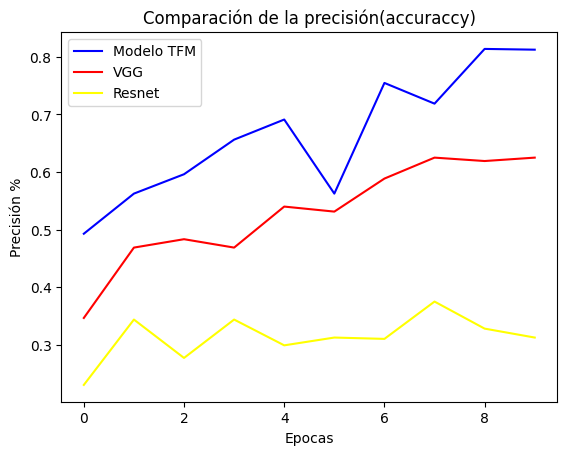

In [9]:
# Precisión de entrenamiento de todos los modelos
print("Comparaciónde la precision")

fig, ax = plt.subplots()
plt.plot(history_custom.history['accuracy'], c='blue', label ='Modelo TFM')
plt.plot(history_vgg.history['accuracy'], c='red', label ='VGG')
plt.plot(history_resnet.history['accuracy'], c='yellow', label ='Resnet')

leg = ax.legend()
plt.xlabel('Epocas')
plt.ylabel('Precisión %')
plt.title("Comparación de la precisión(accuraccy)")
plt.show

Val_ACCURACY Comparacion


<function matplotlib.pyplot.show(close=None, block=None)>

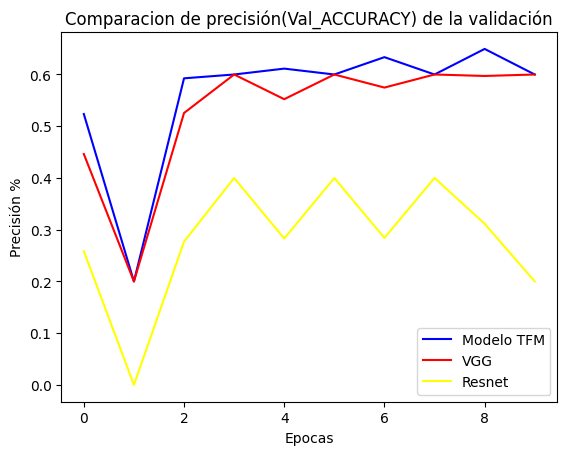

In [10]:
# validación de todos los modelos
print("Val_ACCURACY Comparacion")

fig, ax = plt.subplots()
plt.plot(history_custom.history['val_accuracy'], c='blue', label ='Modelo TFM')
plt.plot(history_vgg.history['val_accuracy'], c='red', label ='VGG')
plt.plot(history_resnet.history['val_accuracy'], c='yellow', label ='Resnet')

leg = ax.legend()

plt.xlabel('Epocas')
plt.ylabel('Precisión %')
plt.title("Comparacion de precisión(Val_ACCURACY) de la validación")
plt.show

Comparacion de la perdida


<function matplotlib.pyplot.show(close=None, block=None)>

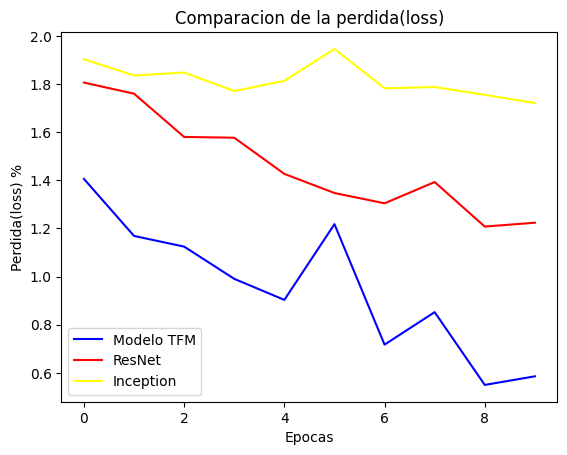

In [11]:
print("Comparacion de la perdida")

fig, ax = plt.subplots()
plt.plot(history_custom.history['loss'], c='blue', label ='Modelo TFM')
plt.plot(history_vgg.history['loss'], c='red', label ='ResNet')
plt.plot(history_resnet.history['loss'], c='yellow', label ='Inception')

leg = ax.legend()

plt.title("Comparacion de la perdida(loss)")
plt.xlabel('Epocas')
plt.ylabel('Perdida(loss) %')
plt.show

Val_LOSS Comparison


<function matplotlib.pyplot.show(close=None, block=None)>

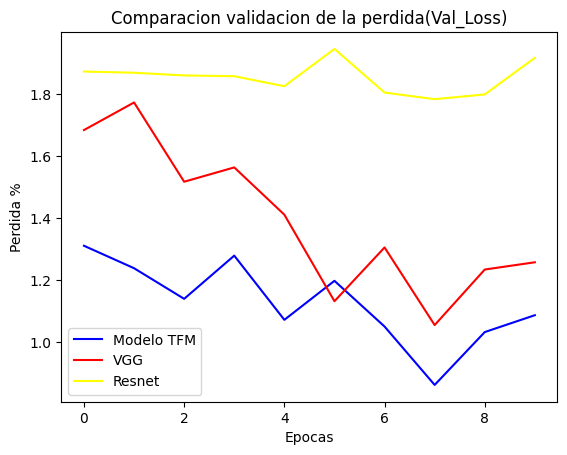

In [12]:
print("Val_LOSS Comparison")

fig, ax = plt.subplots()
plt.plot(history_custom.history['val_loss'], c='blue', label ='Modelo TFM')
plt.plot(history_vgg.history['val_loss'], c='red', label ='VGG')
plt.plot(history_resnet.history['val_loss'], c='yellow', label ='Resnet')

leg = ax.legend()

plt.xlabel('Epocas')
plt.ylabel('Perdida %')
plt.title("Comparacion validacion de la perdida(Val_Loss)")
plt.show

Prueba con una sola image

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved custom model
modelo_tfm = tf.keras.models.load_model('C:/UE/TFM/checkpoint/modelo_tfm_best.keras')

# Define class labels
class_labels = ['Abarth', 'Audi', 'BMW', 'Citroen', 'Hyundai', 'Peugeot', 'Seat', 'Toyota']

# Load and preprocess the single image
img_path = 'C:/UE/TFM/TEST/CARRO_TEST.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create batch dimension
img_array = img_array / 255.0  # Normalize pixel values

# Predict class probabilities
predictions = modelo_tfm.predict(img_array)

# Get the predicted class label and its corresponding accuracy
predicted_index = np.argmax(predictions)
predicted_label = class_labels[predicted_index]
accuracy = predictions[0][predicted_index]

print("Predicted class:", predicted_label)
print("Accuracy:", accuracy)

for i, prob in enumerate(predictions[0]):
    print(f"{class_labels[i]}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: Audi
Accuracy: 0.51277673
Abarth: 0.0113
Audi: 0.5128
BMW: 0.0837
Citroen: 0.0392
Hyundai: 0.1628
Peugeot: 0.0984
Seat: 0.0428
Toyota: 0.0490


Detector de daños

In [4]:
import tensorflow as tf
# Path to your image file
img_path = 'C:/UE/TFM/TEST/fiat-500e-gets-the-hot-abarth-look-raises-some-serious-questions-141653-1-1583769885.png'

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image as in the training process
    return img_array

# Load the trained model
model = tf.keras.models.load_model('C:/UE/TFM/checkpoint/modelo_tfm_best.keras')

# Predict the class probabilities
predictions = model.predict(img_array)

# Get the class labels
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary to get labels

# Display the probabilities for each class
for i, prob in enumerate(predictions[0]):
    print(f"{class_labels[i]}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


NameError: name 'train_generator' is not defined

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Define the base directory where your dataset is located
base_dir = 'C:/UE/TFM/IMAGENES_MCRNN/dataset'

# Parameters
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
epochs = 10
max_seq_length = 20  # Maximum sequence length for CRNN


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Set as training data
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    shuffle=True
)

# Define a CRNN model
def damage_detector_crnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        LSTM(128),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create your custom model with CRNN
input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)
custom_model_crnn = damage_detector_crnn_model(input_shape, num_classes)

# Compile the custom model with CRNN
custom_model_crnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train your custom model with CRNN
history_custom_crnn = custom_model_crnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Plot training and validation accuracy for the custom model with CRNN
plt.figure(figsize=(12, 6))
plt.plot(history_custom_crnn.history['accuracy'], label='Custom Model with CRNN Training Accuracy')
plt.plot(history_custom_crnn.history['val_accuracy'], label='Custom Model with CRNN Validation Accuracy')
plt.title('Training and Validation Accuracy (Custom Model with CRNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 26, 26, 128)